## Mini-Project: Handwritten Digit Recognition in PyTorch

We will use PyTorch to classify image sof handwritten digits. We will use the [MNIST dataset], which contains 28x28 images of handwritten digits from 0 to 9.

We will download the dataset and create train, validation and test splits. The train set will be used to actually train our custom feed-forward network, where as the validation set will only be used to visualize network's performance **during** training. Finally, the test set will be used to evaluate the accuracy of our network **after** the training has finished.



In [1]:
# Import necessary packages
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [2]:
import os
from google.colab import drive

In [3]:
# Create the data loaders

from torch.utils.data import random_split
from torchvision import datasets, transforms


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])


# Download the dataset
trainset = datasets.MNIST('data/MNIST/', download=True, train=True, transform=transform)
testset = datasets.MNIST('data/MNIST/', download=True, train=False, transform=transform)


# TODO: Split the 'trainset' into train and validation sets, and 
generator=torch.Generator().manual_seed(42)
trainset,valset= torch.utils.data.random_split(trainset, [50000, 10000])

# TODO: Create the three data loaders
batch_size=64
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size = batch_size)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size = batch_size)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size = batch_size)





# Print the lengths of all three datasets
print('Train:', len(trainset), 'Val:', len(valset), 'Test:', len(testset))

100%|██████████| 9912422/9912422 [00:00<00:00, 232387280.79it/s]

Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 19541166.93it/s]


Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68025607.35it/s]

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22980131.20it/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw

Train: 50000 Val: 10000 Test: 10000


### Data Exploration

In [5]:
dataiter = iter(trainloader)
images, labels = next(iter(trainloader))
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [6]:
images[0].shape[::-1]

torch.Size([28, 28, 1])

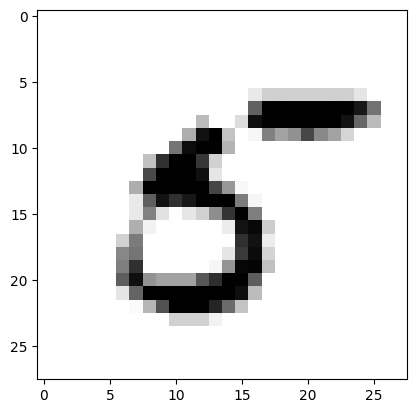

In [7]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

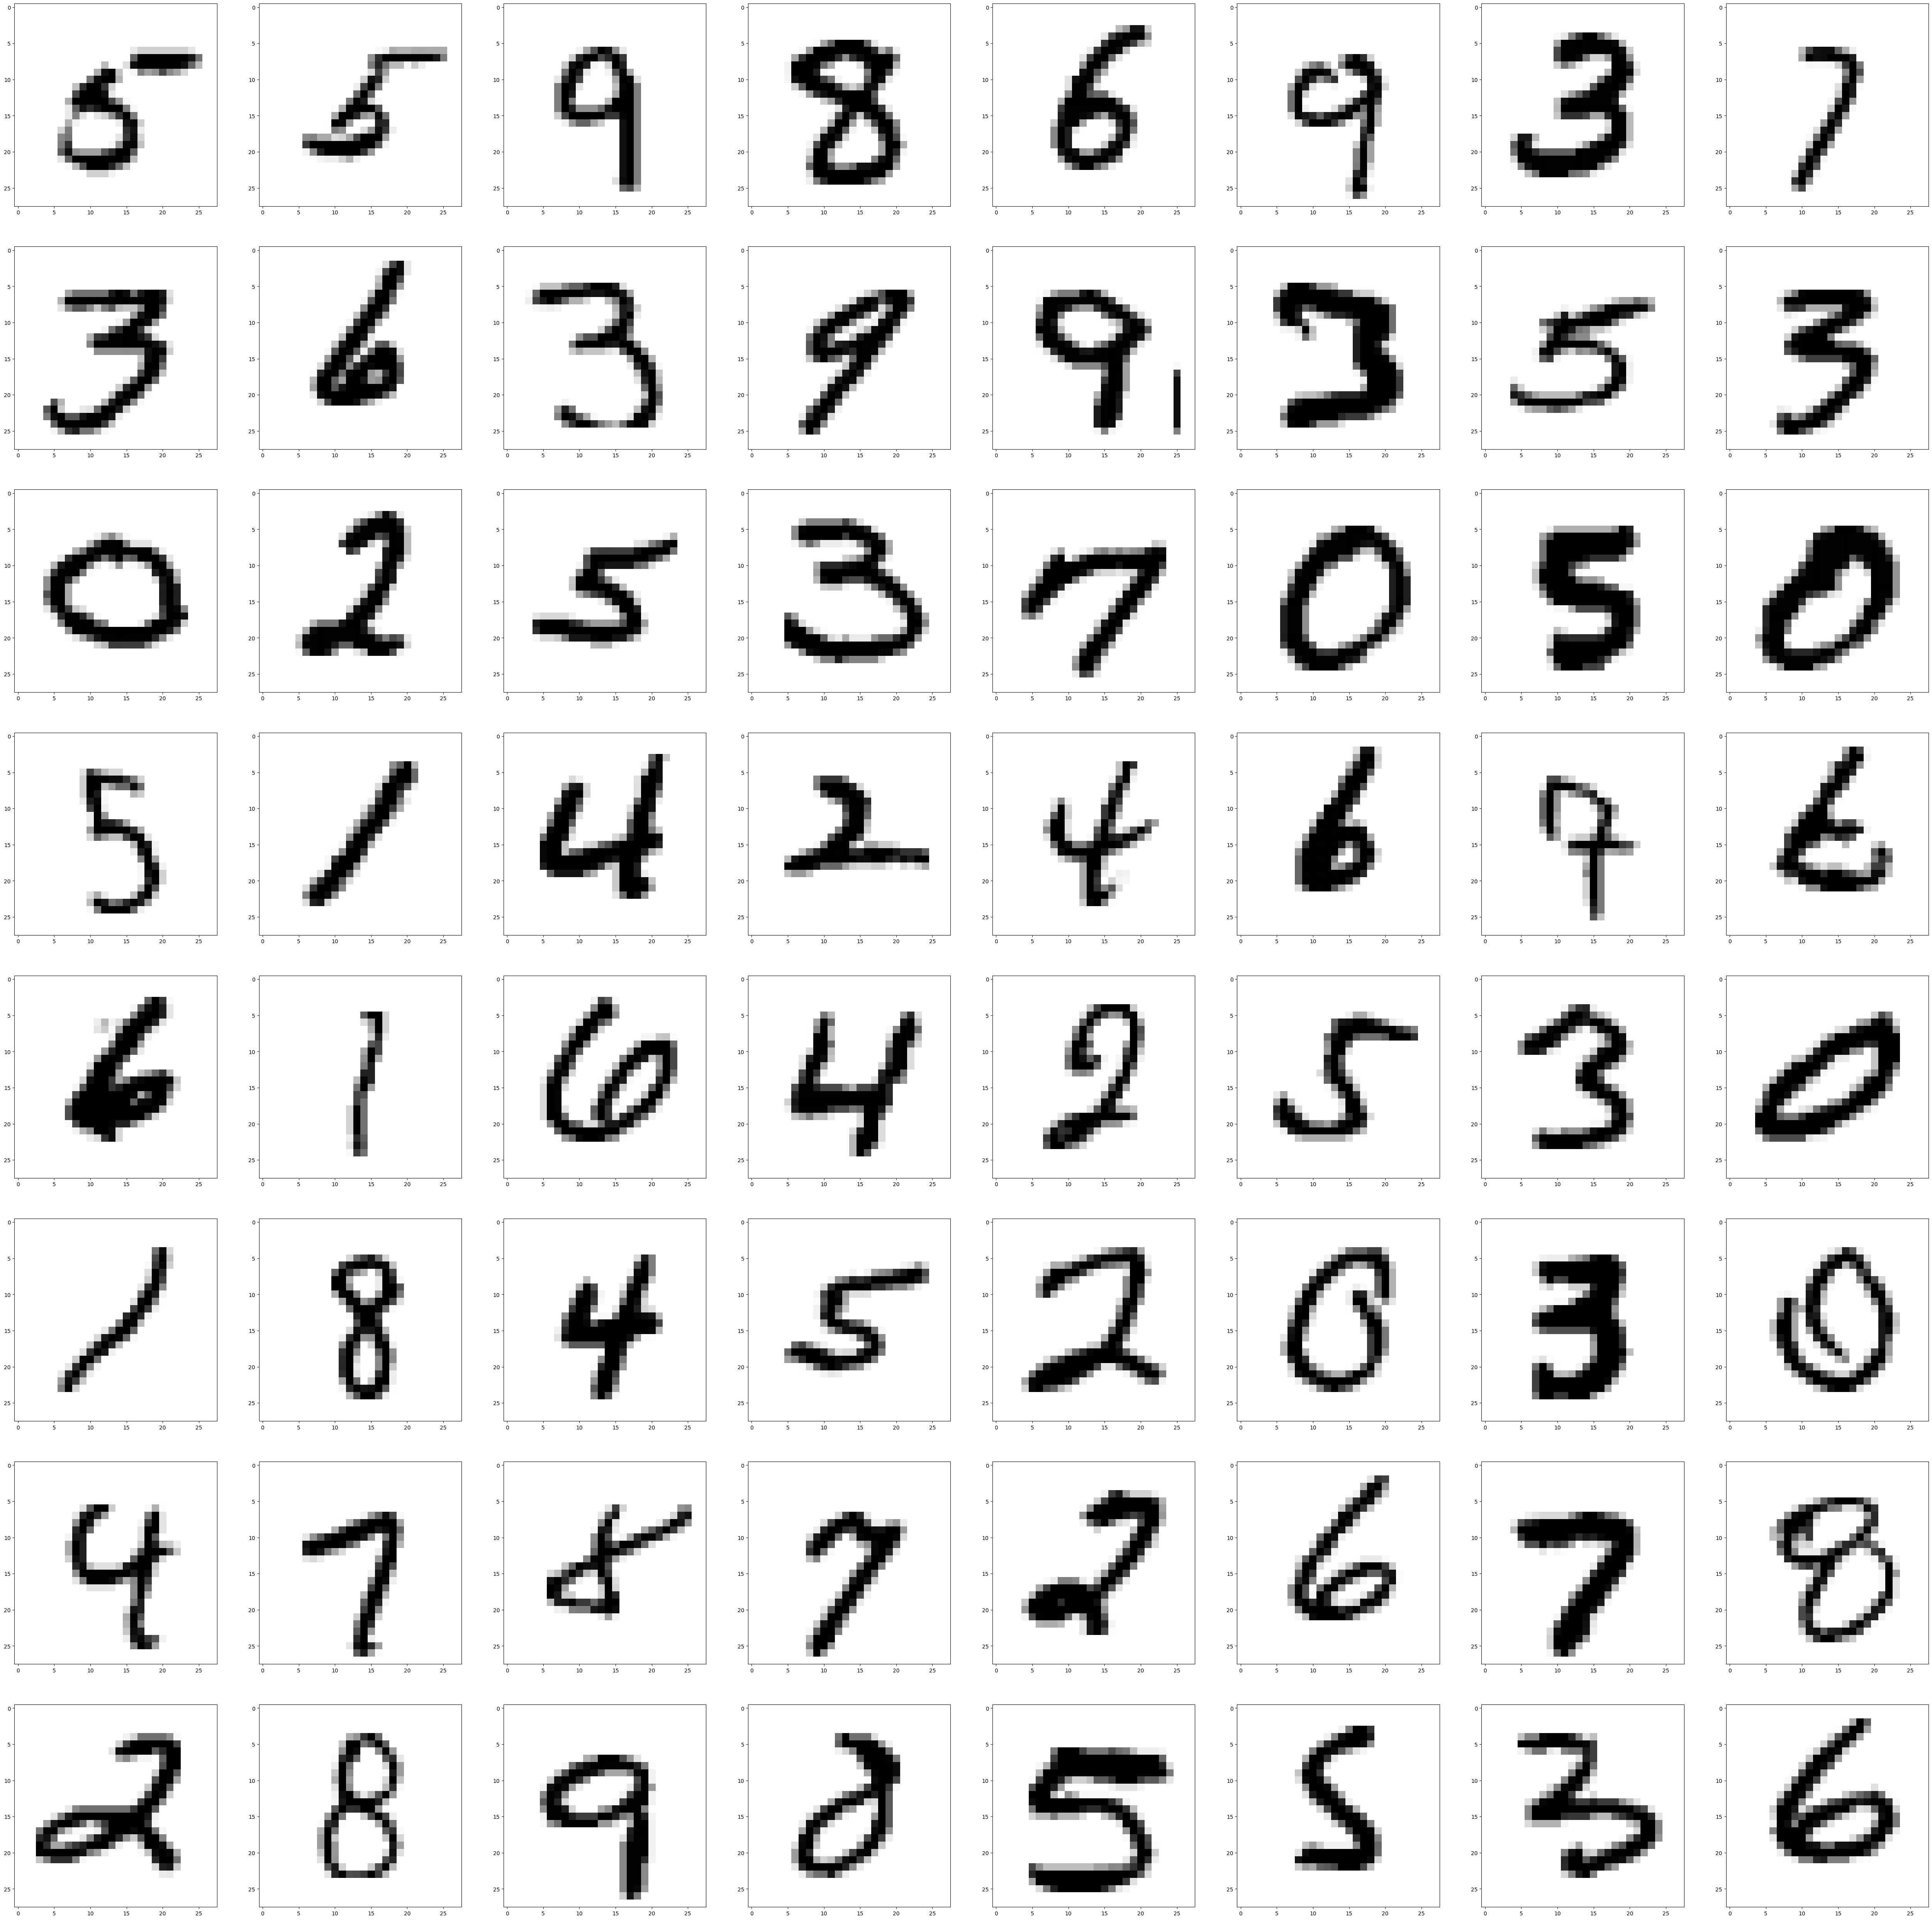

In [8]:
# Visualize all 64 images in the first batch
# of the training set as an 8x8 grid.

figure = plt.figure(figsize=(64,64))
#plt.figure(figsize=(64,64))

for i in range (64):
  
  plt.subplot(8,8,i+1)    
  plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')


plt.show()
plt.close()

### Defining the Neural Network

We create a custome feed-forward network with layers as shown below and verify it's performance.

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [39]:
# Build a feed-forward network
from torch import nn
from torch.nn import Linear, LogSoftmax

class CustomModel(nn.Module):
  def __init__(self):
    super().__init__()
    input_size =  784
    hidden_sizes = [128,64]
    output_size = 10

    #self.flatten = nn.Flatten()
   
    self.hidden = nn.Linear(784, hidden_sizes[0])
    self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
    self.output = nn.Linear(hidden_sizes[1], 10)
    
    #self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    #x = self.flatten(x)
    x = self.hidden(x)
    x = self.hidden1(x)
    x = self.output(x)
    #x = self.softmax(x)
    x = nn.LogSoftmax(dim=1)(x)
          
    return x

model = CustomModel()
print(model)

CustomModel(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


CustomModel(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

### Train the Network

In [41]:

from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

In [42]:
def train_step(x, y, model, optimizer, criterion):
  """ One training step.
  Returns:
    the loss computer for this training step
  """
  x = x.view(x.shape[0], -1) # Reshape to vector of size 784 (28x28=784)
  optimizer.zero_grad()      # Clear existing gradients
  output = model(x.cuda())   # Forward pass
  loss = criterion(output, y.cuda())
  loss.backward()            # Compute new gradients
  optimizer.step()           # Update weights
  return loss

In [43]:
def val_step(x, y, model, optimizer, criterion):
  """ One validation step.
  Returns:
    the loss computer for this validation step
  """
  x = x.view(x.shape[0], -1)
  optimizer.zero_grad()
  output = model(x.cuda())
  loss = criterion(output, y.cuda())
  return loss

In [44]:
time0 = time()
epochs = 25
for e in range(epochs):
    # Training loop
    model.train()  # set to train mode
    running_loss = 0
    for images, labels in trainloader:
        loss = train_step(images, labels, model, optimizer, criterion)
        running_loss += loss.item()

    print("ep {}:\ttrain={:.4f}".format(e, running_loss/len(trainloader)), end='')

    # Validation loop
    model.eval()  # set to evaluation mode
    running_loss = 0
    for images, labels in valloader:
        with torch.no_grad():
            loss = val_step(images, labels, model, optimizer, criterion)
            running_loss += loss.item()

    print("\tval={:.4f}".format(running_loss/len(valloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


ep 0:	train=0.5779	val=0.3743
ep 1:	train=0.3252	val=0.3523
ep 2:	train=0.3078	val=0.3434
ep 3:	train=0.2985	val=0.3373
ep 4:	train=0.2922	val=0.3330
ep 5:	train=0.2875	val=0.3300
ep 6:	train=0.2837	val=0.3279
ep 7:	train=0.2806	val=0.3264
ep 8:	train=0.2780	val=0.3255
ep 9:	train=0.2757	val=0.3249
ep 10:	train=0.2738	val=0.3245
ep 11:	train=0.2720	val=0.3243
ep 12:	train=0.2704	val=0.3242
ep 13:	train=0.2690	val=0.3243
ep 14:	train=0.2677	val=0.3243
ep 15:	train=0.2665	val=0.3244
ep 16:	train=0.2653	val=0.3246
ep 17:	train=0.2643	val=0.3247
ep 18:	train=0.2634	val=0.3248
ep 19:	train=0.2625	val=0.3249
ep 20:	train=0.2616	val=0.3250
ep 21:	train=0.2608	val=0.3251
ep 22:	train=0.2601	val=0.3252
ep 23:	train=0.2594	val=0.3253
ep 24:	train=0.2587	val=0.3253

Training Time (in minutes) = 7.326501969496409


In [45]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 7


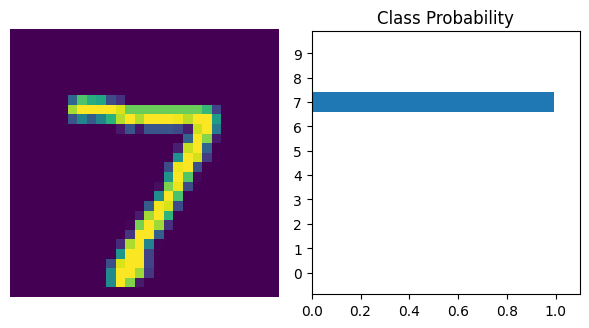

In [46]:
images, labels = next(iter(testloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

### Model Evaluation

In [47]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print(f"\nModel Accuracy = {(correct_count/all_count*100)}%")

Number Of Images Tested = 10000

Model Accuracy = 91.75999999999999%
